# Image Segmentation

This notebook implementes the final work of SCC0251 - Image Processing class. We aim to use four different methods of image segmentation applied to two datasets - one composed by forest images (1) and another one composed with drone aereal images (2). The datasets have the following characteristics:

    1. Wildfire images. This dataset does not count with ground truth segmented images, so we do not have a proper way to verify how accurate is our segmentation. In the other hand, to deal with wildfires is an important task nowadays, since we are passing through increasing problems related to climate changes;
    2. Aereal drone images of urban contexts. This dataset contains the images to be segmented, but also contains some ground truth images, which allows us to perform a comparison between the output produced by our implementations and the expected result.
   
This notebook is organized as following:
    
    0. Define algorithms - import libraries, define modules of each algorithm used and methods to show segmented images and compute errors according to the ground truth segmentation
    1. Drone Urban Images - compute segmentations, show segmented images and error for a specific image

## 0. Define Algorithms

In [39]:
# Import libraries

import os
import random
import math
import numpy as np
import imageio as io

import scipy
from scipy import ndimage as ndi
from scipy import stats

from skimage import color
from skimage import filters
from skimage.segmentation import mark_boundaries
from skimage.segmentation import felzenszwalb
from skimage.segmentation import watershed
from skimage.segmentation import slic
from skimage.morphology import disk
from skimage.filters import rank
from skimage.util import img_as_ubyte
from skimage.filters import sobel
from skimage import morphology
from skimage.metrics import (adapted_rand_error,
                              variation_of_information)

import matplotlib.pyplot as plt

In [38]:
def normalize(matrix, start, end):
    """
    Apply normalization to the image
    
    Parameters
    ----------
        matrix: np.array
            The original image to be normalized
        start: int
            Minimum value to the final image
        end: int
            Maximum value to the final image
            
    Returns
    -------
        matrix_norm: np.array
            Normalized version of the original image 
    """
    return (matrix - matrix.min())/(matrix.max() - matrix.min()) * (end-start) + start

In [3]:
def apply_otsu(img_orig_gs, bins = 256, min_v = 0, max_v = 256):
    """
    Apply OTSU segmentation method to the image. The image must be gray scale.
    
    Parameters
    ----------
        img_orig_gs: array
            Original image in gray scale
        bins: int 
            number of histogram bins
        min_v: int
            Minimum value of the histogram. The default value is 0
        max_v: int
            Maximum value of the histogram. The default value is 256
    
    Returns
    -------
        hist: array
            Histogram of the original gray scaled image
        img_ths: array
            Segmented image
        hist_ths: array
            Histogram of the segmented image    
    """
    
    # 1. Compute histogram
    hist, _ = np.histogram(img_orig_gs, bins=bins, range=(min_v,max_v)) # compute histogram of the original gray scale image

    # 2. Compute threshold
    ths = filters.threshold_otsu(img_orig_gs) # compute threshold
    img_ths = img_orig_gs < ths # filter image with the computed trheshold
    hist_ths, _ = np.histogram(img_ths, bins=bins, range=(min_v,max_v)) # compute histogram of the segmented image
    
    return hist, img_ths, hist_ths

In [34]:
def apply_watershed(img_orig_gs, seeds_num = 8, bins = 256, min_v = 0, max_v = 256):
    """
    Apply Watershed segmentation method to the image. The image must be gray scale.
    
    Parameters
    ----------
        img_orig_gs: array
            Original image in gray scale
        seeds_num: int
            number of seeds for watershed method. This will be the final number of segmented areas
        bins: int 
            number of histogram bins
        min_v: int
            Minimum value of the histogram. The default value is 0
        max_v: int
            Maximum value of the histogram. The default value is 256    
    
    Returns
    -------
        segmentation: array
            Segmented image
    """
    
#     image = img_as_ubyte(img_orig_gs)

#     # denoise image
#     denoised = rank.median(image, disk(2))

#     # find continuous region (low gradient -
#     # where less than 10 for this image) --> markers
#     # disk(5) is used here to get a more smooth image
#     markers = rank.gradient(denoised, disk(5)) < 10
#     markers = ndi.label(markers)[0]

#     # local gradient (disk(2) is used to keep edges thin)
#     gradient = rank.gradient(denoised, disk(2))

#     # process the watershed
#     segmentation = watershed(gradient, markers)
    
    #---------------------------------------------
    
    # 1. Define random seeds
    random_seeds = np.zeros(img_orig_gs.shape) 
    indices = np.random.randint(0, img_orig_gs.shape, [seeds_num, 2])
    random_seeds[indices[:, 0], indices[:, 1]] = img_orig_gs[indices[:, 0], indices[:, 1]]
    
    # 2. Compute mask to improve results
    random_seeds = morphology.dilation(random_seeds, morphology.disk(4)).astype(np.uint8) 
    elevation_map = sobel(img_orig_gs)
    
    # 3. Compute watershed segmentation
    segmentation = watershed(elevation_map, random_seeds)

    # 4. Compute histograms
    elev_ths, _ = np.histogram(elevation_map, bins=bins, range=(min_v,max_v))
    seg_ths, _ = np.histogram(segmentation, bins=bins, range=(min_v,max_v))
    rand_ths, _ = np.histogram(random_seeds, bins=bins, range=(min_v,max_v))
    
    return segmentation

In [5]:
def apply_slic(img_orig, n_segments=15):
    """
    Apply Slic segmentation method to the image. It is not mandatory, but the method works better with RGB images
    
    Parameters
    ----------
        img_orig: array
            Original image in gray scale
        n_segments: int
            Number of segmented areas        
        
    Returns
    -------
        slic_img: array
            Boundaries of each segmented area
        marked_image: array
            Original image with segmented boundaries marked    
    """
    
    # 1. Apply SLIC method creating an object with the boundaries
    slic_img = slic(img_orig, n_segments=n_segments)
    
    # 2. Mark the boundaries created to the original image
    marked_image = mark_boundaries(img_orig, slic_img)
    
    return slic_img, marked_image

In [6]:
def apply_felzenszwalbs(img_orig, scale, sigma, min_size):
    """
    Apply Felzenszwalb's segmentation method to the image. It is not mandatory, but the method works better with RGB images
    
    Parameters
    ----------
        img_orig: array
            Original image in gray scale
        scale:
        
        sigma:
        
        min_size:
        
        
    
    Returns
    -------
        segments_fz: array
            Boundaries of each segmented area
        marked_image: array
            Original image with segmented boundaries marked    
    
    """
    
    # 1. Apply Felzenszwalb's method creating an object with the boundaries
    segments_fz = felzenszwalb(img_orig, scale=scale, sigma=sigma, min_size=min_size)
    
    # 2. Mark the boundaries created to the original image
    marked_image = mark_boundaries(img_orig, segments_fz)
    
    return segments_fz, marked_image

In [7]:
def compute_segmentations(img_orig, img_orig_gs):
    """
    Compute the segmented image for the original image using the gour methods difined: OTSU, Watershed, SLIC and Felzenszwalb's
    
    Parameters
    ----------
        img_orig: array
            Original image in gray scale
        img_orig_gs: array
            Original image in gray scale
    
    Returns
    -------
        img_dict: dict
            Dictionary with the resulting segmented images of the original image. Each Key relates to one method, and its value is an array with the segmented image
        
    """
    
    # 1. Compute segmentations using the proposed algorithms    
    hist, otsu_img, hist_ths = apply_otsu(img_orig_gs, bins = 256, min_v = 0, max_v = 256)
    watershed_img = apply_watershed(img_orig_gs, seeds_num = 8, bins = 256, min_v = 0, max_v = 256)
    slic_img, marked_image_slic = apply_slic(img_orig, n_segments=15)
    segments_fz, marked_image_fz = apply_felzenszwalbs(img_orig, scale=100, sigma=0.5, min_size=50)
    
    
    return {'otsu': otsu_img, 'watershed': watershed_img, 'slic': marked_image_slic, 'felzenszwalb': marked_image_fz}    

In [8]:
def show_img_comparison(img_dict, img_orig, img_orig_gs, img_gt=None, figsize=(30, 20)):
    """
    Plot the original image, the original gray scale image, the ground truth segmented image (if it exists) and each one of the computed segmented images
    
    Parameters
    ----------
        img_dict: dict
            Dictionary with the resulting segmented images of the original image. Each Key relates to one method, and its value is an array with the segmented image
        img_orig: array
            Original image in gray scale
        img_orig_gs: array
            Original image in gray scale
        img_gt: array
            Ground truth segmented images
        fig_size: tuple
            Size of the figure 
    
    """
    
    # 0. Define number of images, number of rows and plot region
    n_images = len(img_dict) + (2 if img_gt is None else 3)
    n_rows = math.ceil(n_images/3)
    
    fig, axes = plt.subplots(n_rows,3, figsize=figsize, sharex=True, sharey=True)
    
    # 1. Plot original image and ground truth segmented image
    axes[0, 0].imshow(img_orig); axes[0, 0].axis('off'); axes[0,0].set_title('Original Image')
    axes[0, 1].imshow(img_orig_gs, cmap='gray'); axes[0, 1].axis('off'); axes[0,1].set_title('Original Image Gray Scale')
    
    i = 0; j = 2
    
    # Plot ground truth image, if it exists
    if img_gt is not None:
        axes[0, 2].imshow(img_gt, cmap='gray'); axes[0, 2].axis('off'); axes[0,2].set_title('Ground Truth Segmented Image')
        i = 1; j = 0
    
    # 2. PLot s#egmented images produced
    for img in img_dict:
        axes[i, j].imshow(img_dict[img], cmap='gray'); axes[i, j].axis('off'); axes[i,j].set_title(img)
        if j == 2: i = i + 1
        j = (j + 1) % 3  

In [27]:
def compute_show_errors(img_dict, img_gt, show_metrics=True):
    """
    Compare the segmented computed image to the ground truth computed images. The results metrics are: error, precision, recall, splits and merges
    
    Parameters
    ----------
        img_dict: dict
            Dictionary with the resulting segmented images of the original image. Each Key relates to one method, and its value is an array with the segmented image
        img_gt: array
            Ground truth segmented images
        show_metrics: boll
            Defines wether the metrics will be printed or not
    
    Returns
    -------
        metrics: dict
            Dictionary containning metrics for each of the algorithms used. Each key relates to one algorithm, and its values are another dictionary containning all the five metrics
    
    """
    
    # 1. Compute metrics
    metrics = {} # instantiate metrics dictionary to be filled with the metrics
    for img in img_dict:
        # if the segmented image is a RGB, we must convert to gray scale since the ground truth image isa gray scale image
        img_gray = img_dict[img]
        if len(img_dict[img].shape) > 2:
            img_gray = color.rgb2gray(img_dict[img])
            img_gray = normalize(img_gray, 0, 255).astype(np.uint8)
        
        # Compute metrics
        error, precision, recall = adapted_rand_error(img_gray, img_gt)
        splits, merges = variation_of_information(img_gray, img_gt)
        
        # Stores metrics
        metrics[img] = {'error': error, 'precision': precision, 'recall': recall, 'splits': splits, 'merges': merges}
    
    # 2. Print metrics, if desired
    if show_metrics:
        print("{:<20} {:<20} {:<20} {:<20} {:<20} {:<20}".format('Algorithm','error','precision', 'recall', 'splits', 'merges'))

        for alg, m in metrics.items():
            print("{:<20} {:<20} {:<20} {:<20} {:<20} {:<20}".format(alg, m['error'], m['precision'], m['recall'], m['splits'], m['merges']))
    
    
    return metrics
        

## 1. Drone Urban Images

In [10]:
label = '000.jpg'

img_orig = io.imread(label)
img_orig_gs = color.rgb2gray(img_orig)
img_orig_gs = normalize(img_orig_gs, 0, 255).astype(np.uint8)

label = '000_label.png'

img_gt = io.imread(label)

In [35]:
# 1. Compute segmentations
img_dict = compute_segmentations(img_orig, img_orig_gs)

c:\users\caiof\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  after removing the cwd from sys.path.


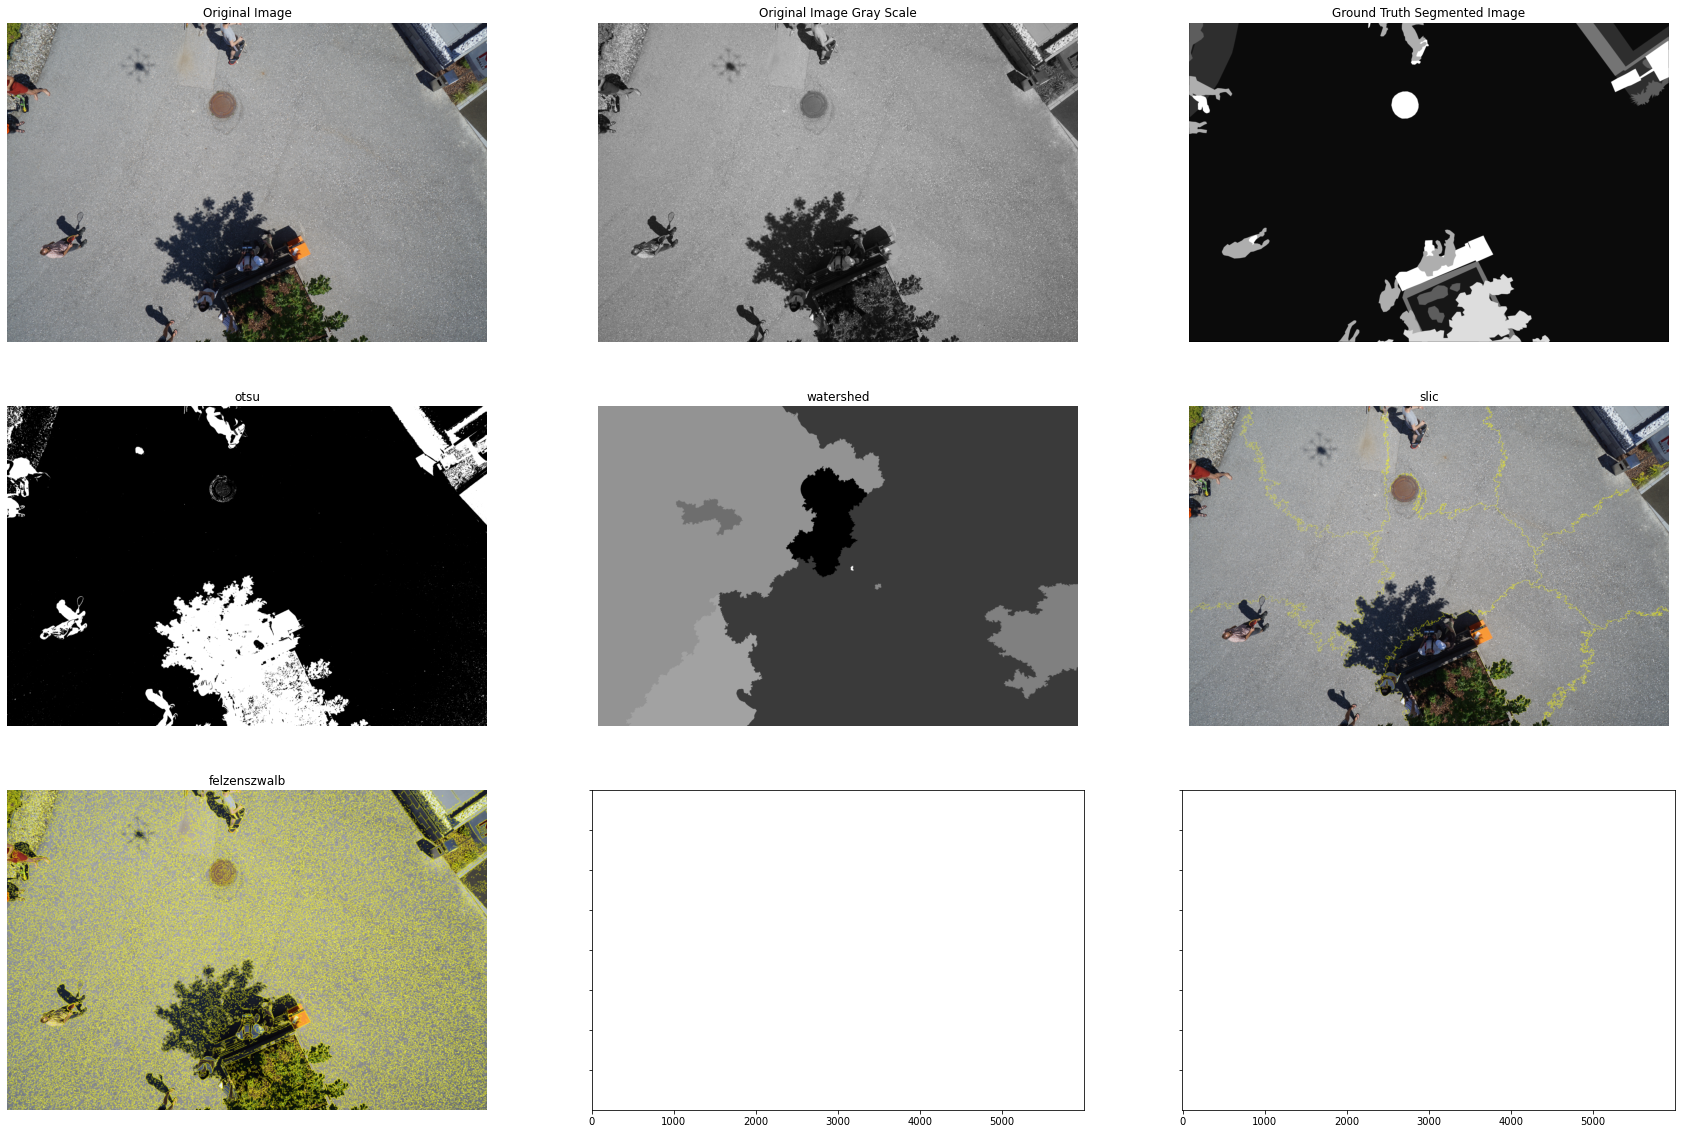

In [36]:
# 2. Show images to visual comparison
show_img_comparison(img_dict, img_orig, img_orig_gs, img_gt=img_gt, figsize=(30, 20))

In [37]:
# 3. Compute and show metrics
metrics = compute_show_errors(img_dict, img_gt, show_metrics=True)

Algorithm            error                precision            recall               splits               merges              
otsu                 0.6399117320327249   0.21957783515636772  1.0                  0.7331791394871082   0.4046518447710336  
watershed            0.49759042112984675  0.722441580975665    0.3851159087872378   0.845153454255921    1.5582906791011588  
slic                 0.975170608771282    0.9226432937469228   0.012584020844870722 0.6501789731694745   6.751512193978977   
felzenszwalb         0.895975419664183    0.7776790346573761   0.05574028011515897  0.7013210925290028   6.026427407531761   


## 2. Wildfire Images

c:\users\caiof\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  after removing the cwd from sys.path.


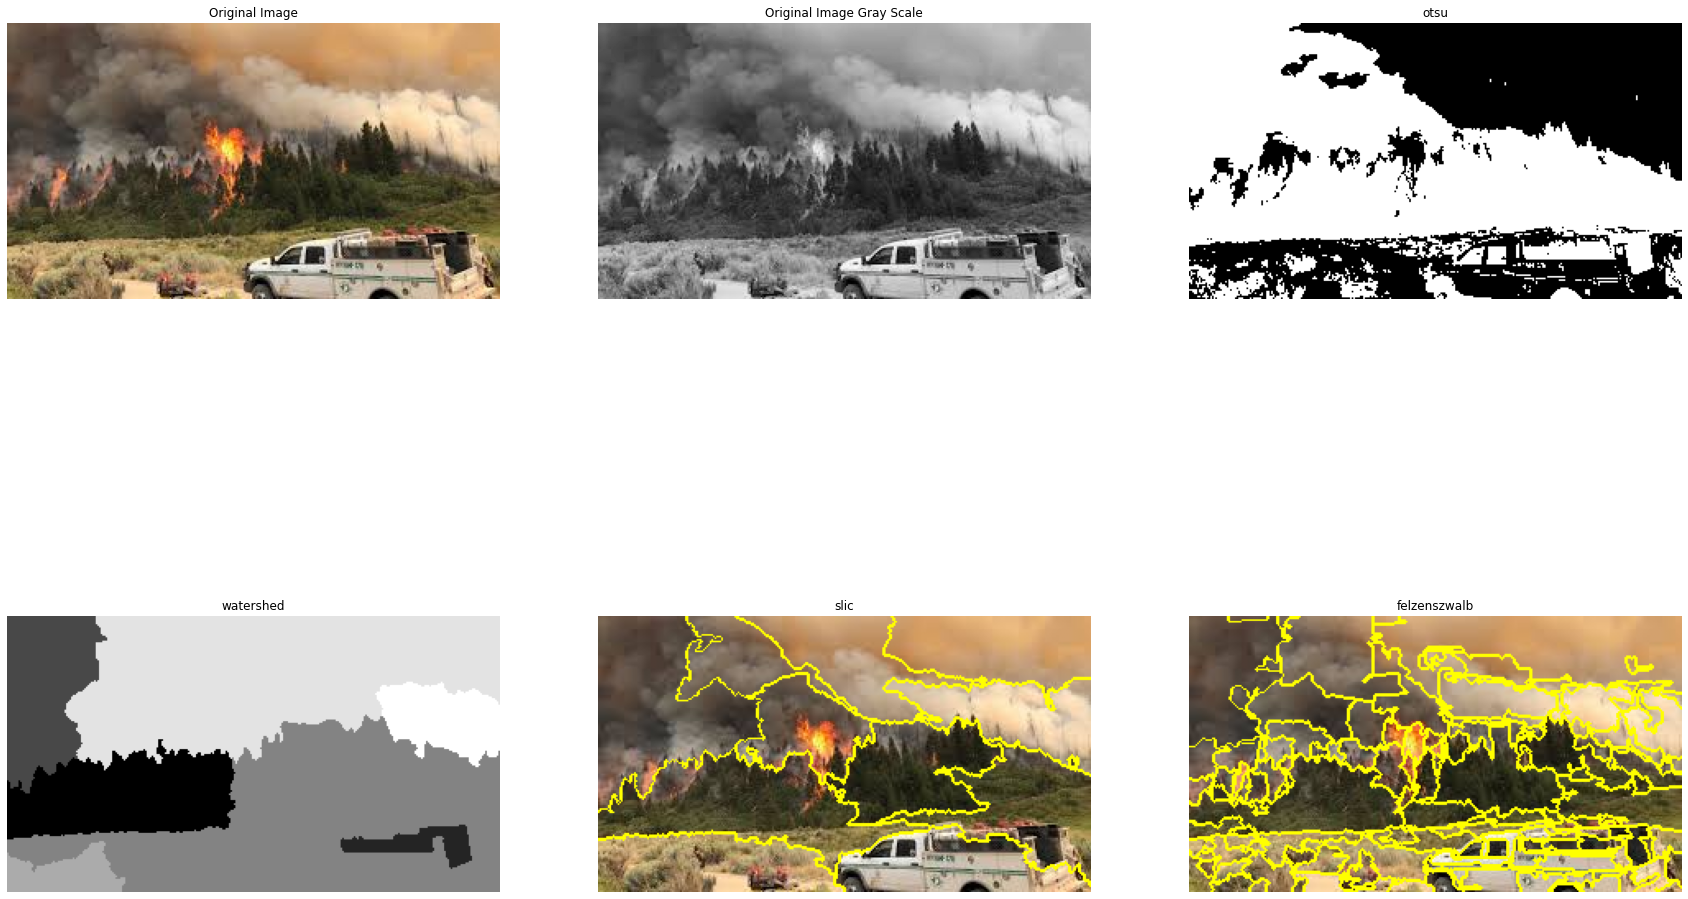

In [54]:
# 0. Load image
# 0.1. Randomly select one of the possible images
path = "C:/Users/caiof/Documents/forest_image_segmentation/fire_seg_test/"
files=os.listdir(path)
label=random.choice(files)

# 0.2. Load image and create a gray scale copy
img_orig = io.imread(path+label)
img_orig_gs = color.rgb2gray(img_orig)
img_orig_gs = normalize(img_orig_gs, 0, 255).astype(np.uint8)

# 1. Compute segmentations
img_dict = compute_segmentations(img_orig, img_orig_gs)

# 2. Show images to visual comparison
show_img_comparison(img_dict, img_orig, img_orig_gs, figsize=(30, 20))